In [ ]:
# Cha[ter 1. Transfer Leaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
chap1_path = "drive/MyDrive/Colab\ Notebooks/chap1" 
data_path = chap1_path + "/data/"

In [ ]:
!ls $data_path

cifar-10  golden.jpg  imgnet1000.txt


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torchvision
from torchvision import models, transforms

In [ ]:
# Check Versions
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [ ]:
# Create an instance of VGG-16
net = models.vgg16(pretrained=True) #학습된 파라미터를 사용하는 vgg-16 model을 읽어옴
net.eval() # 추론 모드로 설정 // 추론을 실행하기전에 호출을 안해줄경우 드롭아웃 및 배치 정규화를 평가모드로 설정을 해야함 -> 안그럴 경우 추론 결과가 일관성 없이 출력이된다.

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torchsummary import summary

In [ ]:
# # parameter  수를확인 할수있다.
# summary(net, input_size=(3,224,224))

### 1) Download CIFAR-10 & ToTensor

In [ ]:
!mkdir $data_path/cifar-10

mkdir: cannot create directory ‘drive/MyDrive/Colab Notebooks/chap1/data//cifar-10’: File exists


In [ ]:
from torchvision import datasets

In [ ]:
cifar_path = data_path + "/cifar-10/"
cifar10 = datasets.CIFAR10(cifar_path, train = True, download=True)
cifar10_val = datasets.CIFAR10(cifar_path, train = False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [ ]:
len(cifar10)

50000

In [ ]:
len(cifar10_val)

10000

In [ ]:
img, label = cifar10[7]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7F8B1C0A90>, 7)

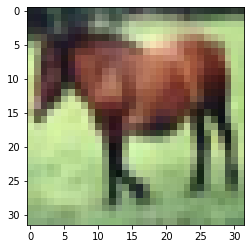

In [ ]:
plt.imshow(img)
plt.show()

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape # 3-channel(RGB) 32x32 image

torch.Size([3, 32, 32])

In [ ]:
# 한번에 하기
tensor_cifar10 = datasets.CIFAR10(cifar_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
img_t, _ = tensor_cifar10[7]
type(img_t)

In [ ]:
plt.imshow(img_t.permute(1, 2, 0)) # CxHxW(tensor) -> HxWxC(image) , tensor와 이미지의 차원 배열 순서가 다름 
plt.show()

### 2) Normalization

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

In [ ]:
imgs.view(3,1024,50000).shape 

In [ ]:
imgs.view(3,-1).shape # 3 x ? 를 만들어줌 , ?는 pytorch 를 만들어줌 

In [ ]:
imgs.view(3,-1,50000).shape

In [ ]:
imgs.view(3,-1).mean(dim=1) # (3,51200000) -> mean -> (3,) 

In [ ]:
imgs.view(3,-1).std(dim=1)

In [ ]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

In [ ]:
# Totensor과 함께 한번에 하기!
transformed_cifar10 = datasets.CIFAR10(
    cifar_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        )
    ])
)
    

In [ ]:
img_t,_ = transformed_cifar10[7]
plt.imshow(img_t.permute(1,2,0))
plt.show()

### 3. Convolution

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3) # channel, Batch size, kernel size
conv

In [ ]:
conv.weight.shape, conv.bias.shape

In [ ]:
img, _ =tensor_cifar10[7]

In [ ]:
output = conv(img.unsqueeze(0)) # 원하는 자리에 1을 끼워주는거
img.unsqueeze(0).shape, output.shape

In [ ]:
plt.imshow(output[0,0].detach(),cmap='gray') # cmap='gray' 안해주면 생상을 임의로 지정 해준다 
plt.show()                     #  detach() == detach.numpy / tensor 는 plt이 안되서  numpy로 바꿔줌 

In [ ]:
plt.imshow(output[0,1].detach(),cmap='gray') # cmap='gray' 안해주면 생상을 임의로 지정 해준다 
plt.show()

### padding 

In [ ]:
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

In [ ]:
plt.imshow(output[0,0].detach(),cmap="gray")
plt.show()

In [ ]:
# edge detection 
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad(): # no_grad() error backpropagation을 안해줌 : 만약 하게되면 값이 이상하게 나옴
    conv.weight[:] = torch.tensor([
        [-1.0, -1.0, -1.0], # edge detection kenel 3개중 하나 . 구글링하면 detection종류 별로 다른것도 다 나옴   
        [-1.0,  8.0, -1.0],
        [-1.0, -1.0, -1.0]
    ])
    conv.bias.zero_()

In [ ]:
output = conv(img.unsqueeze(0)) 
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

### 5.pooling

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
output.shape

In [ ]:
plt.imshow(output[0,0].detach(),cmap='gray')
plt.show()

In [ ]:
activate = nn.ReLU()
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
output = activate(output)
output = pool(output)

plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()  

### 1.1.6 create preprocess Class

In [ ]:
class BaseTransform():
  """
    Attributes
    ----------
    resize:   int
    mean: (R,G,B)
    std:  (R,G,B)
  """
  def __init__(self,resize,mean,std):
    self.base_transform = transforms.Compose([
      transforms.Resize(resize),
      transforms.CenterCrop(resize),
      transforms.ToTensor(),
      transforms.Normalize(mean,std)
    ])

  def __call__(self,img): # 함수가 호풀되면 이 call함수를 불러내온다. 함수역할을 해주게 해줌!
    return self.base_transform(img)

In [ ]:
image_path = "drive/MyDrive/Colab Notebooks/chap1/data/golden.jpg"
img = Image.open(image_path)

plt.imshow(img)
plt.show()

In [ ]:
resize = 224
mean = (0.485, 0.456, 0.40) # image net에서 정해진 mean,std가 주어져 있다 
std = (0.229, 0.224, 0.225) #  왜냐면 안주어지면 천만장을 다 구해야 하니 ..ㅎㅎㅎ
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)
img_transformed.shape

In [ ]:
img_transformed[0].max(), img_transformed[0].min()

In [ ]:
plt.imshow(img_transformed.permute(1, 2, 0))
plt.show()

In [ ]:
img_permuted = img_transformed.permute(1, 2, 0)
img_permuted = torch.clip(img_permuted,0,1) # 값의 범위를 0~1로 맞춤 

plt.imshow(img_permuted)
plt.show()

## 1.1.7 create post-process clas

1. google 에서  imagenet class index 검색
2. yrebar의 gist에서 raw를 누른 후 save page as 로 다운로드 
3. colab에 업로드

In [ ]:
class ILSVRCPredictor():
  # class index: dictionary 
    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        maxid = torch.argmax(out).item()
        predicted_label_name = self.class_index[maxid]
        return predicted_label_name

### 1.1.8 Use pretrained VGG to predict

In [ ]:
with open("drive/MyDrive/Colab Notebooks/chap1/data/imgnet1000.txt") as f : 
  idx2label = eval(f.read()) # 읽은 것을 python 객체에 대응 

idx2label

In [ ]:
predictor = ILSVRCPredictor(idx2label)

In [ ]:
input_img_t = img_transformed.unsqueeze(0)
out_img_t = net(input_img_t) 
result = predictor.predict_max(out_img_t)

In [ ]:
print("입력 화상의 예측",result)

### 1.2.1 deeplearning flow for pytorch

1. 전처리, 후처리 ,네트워크 모델의 입출력 확인
2. 데이터 셋 작성
3. 데이터 로더 작성
4. 네트워크 모델 작성
5. For ward 정의
6. loss 함수 정의
7. optimizer 기법 정의
8. 학습/검증 실시(train/vaildate)
9. 테스트 데이터로 주문 (test)